In [211]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import directory_functions as dirfuncs
import gather_middleware_statistics as gmws
import cut_away_warmup_cooldown as cut
from cycler import cycler
np.set_printoptions(threshold=np.nan)

In [2]:
# What should be the granularity of the memtier response time interpolation?
granularity = 0.01

In [3]:
# Extract GET histogram from single memtier logfile
def parse_line(line):
    split = line.split()
    return (split[1], split[2])
def extract_GET_histogram(client_logfile_path):
    with open(client_logfile_path, "r") as logfile:
        return [parse_line(line)for line in logfile if line.startswith("GET")]

In [4]:
def extract_GET_throughput(client_logfile_path):
    with open(client_logfile_path, "r") as logfile:
        for line in logfile:
            if line.startswith("Gets"):
                split_line = line.split()
                return float(split_line[1])

In [5]:
def interpolate_histogram(hist, granularity):
    rowcount = hist.shape[0]
    desired_steps = np.arange(start=hist[0, 0], stop=hist[rowcount-1, 0], step=granularity)
    return desired_steps, np.interp(desired_steps, hist[:,0], hist[:,1])

In [39]:
def combine_interpolated_and_real_histogram(real, interpolated, xput, granularity):
    concat = np.concatenate([real, np.vstack(interpolated).transpose()])
    sorted = concat[concat[:,0].argsort()]

    shifted = np.hstack([sorted[:-1,:], sorted[1:,:]])
    shifted_frame = pd.DataFrame(data=shifted, columns=['responsetime_unshifted', 'percentile_unshifted', 'responsetime', 'percentile'])
    shifted_frame['num_requests'] = shifted_frame['percentile'] * xput / 100
    shifted_frame['num_requests_unshifted'] = shifted_frame['percentile_unshifted'] * xput / 100
    shifted_frame['requests'] = (shifted_frame['num_requests'] - shifted_frame['num_requests_unshifted'])

    return shifted_frame.loc[:, ['responsetime', 'percentile', 'requests']]

In [7]:
def calculate_responsetime_percentiles(histogram_arrays, throughputs, granularity):
    interpolated = [interpolate_histogram(hist, granularity) for hist in histogram_arrays]
    combined_histograms = [combine_interpolated_and_real_histogram(real, interp, xput, granularity) for real, interp, xput in zip(histogram_arrays, interpolated, throughputs)]
    return pd.concat(combined_histograms)

In [206]:
# Extracting histograms for Sharded
exp5_1_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912"
experiments = ["sharded_1multiget", "sharded_3multiget", "sharded_6multiget", "sharded_9multiget"]
client_logfiles = ["client_01_0.log", "client_01_1.log", "client_02_0.log", "client_02_1.log", "client_03_0.log", "client_03_1.log"]
reps = 3
exp_filepaths = [[os.path.join(exp5_1_dir, experiment, str(rep), logfiles) for rep in range(1, reps+1) for logfiles in client_logfiles] for experiment in experiments]
exp_histograms = [[np.array(extract_GET_histogram(filepath), dtype=float) for filepath in filepaths] for filepaths in exp_filepaths]
exp_throughputs = [[extract_GET_throughput(filepath) for filepath in filepaths] for filepaths in exp_filepaths]
hist_data_sharded = [calculate_responsetime_percentiles(histograms, throughputs, granularity) for histograms, throughputs in zip(exp_histograms, exp_throughputs)]


In [207]:
# Extracting histograms for Non-Sharded
exp5_2_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp5/5_2_multigets_nonsharded_2017-11-24_092308"
experiments = ["nonsharded_1multiget", "nonsharded_3multiget", "nonsharded_6multiget", "nonsharded_9multiget"]
client_logfiles = ["client_01_0.log", "client_01_1.log", "client_02_0.log", "client_02_1.log", "client_03_0.log", "client_03_1.log"]
reps = 3
exp_filepaths = [[os.path.join(exp5_2_dir, experiment, str(rep), logfiles) for rep in range(1, reps+1) for logfiles in client_logfiles] for experiment in experiments]
exp_histograms = [[np.array(extract_GET_histogram(filepath), dtype=float) for filepath in filepaths] for filepaths in exp_filepaths]
exp_throughputs = [[extract_GET_throughput(filepath) for filepath in filepaths] for filepaths in exp_filepaths]
hist_data_nonsharded = [calculate_responsetime_percentiles(histograms, throughputs, granularity) for histograms, throughputs in zip(exp_histograms, exp_throughputs)]


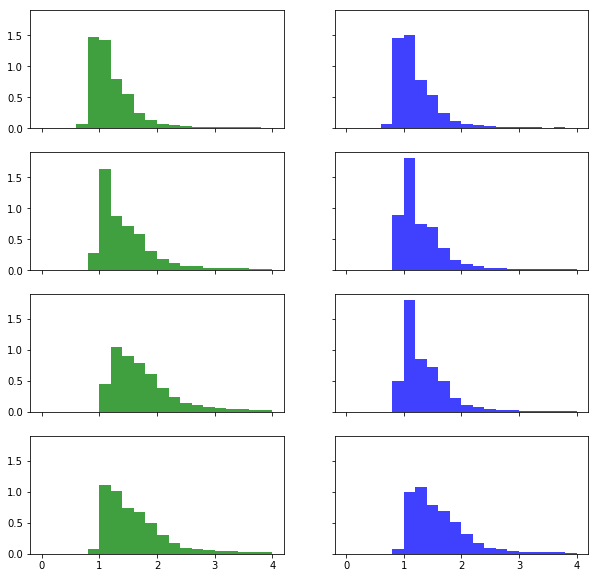

In [42]:
# Plot total histograms
xrng = [0, 4]
buckets = 20
num_subplots = len(hist_data_sharded)
fig, axes = plt.subplots(num_subplots, 2, sharey=True, sharex=True, figsize=(10,10))
for i in range(0, num_subplots):
    axes[i, 0].hist(hist_data_sharded[i]['responsetime'], buckets, weights=hist_data_sharded[i]['requests'], range=xrng, normed=1, facecolor='green', alpha=0.75)
    axes[i, 1].hist(hist_data_nonsharded[i]['responsetime'], buckets, weights=hist_data_nonsharded[i]['requests'], range=xrng, normed=1, facecolor='blue', alpha=0.75)
    
#axes.set_xlim(range)
plt.show()

In [89]:
# Percentile plot
multigets = [1, 3, 6, 9]
desired_percentiles = [25, 50, 75, 90, 99]

def extract_percentiles(hist_data, multigets, percentiles):
    percentile_list = []
    for i in range(0,4):
        data = hist_data[i]
        percentile_list.extend([(multigets[i], perc, data[data['percentile'] >= perc].iloc[0].responsetime) for perc in percentiles])
    return pd.DataFrame(data=percentile_list, columns=['multigets', 'percentile', 'responsetime'])

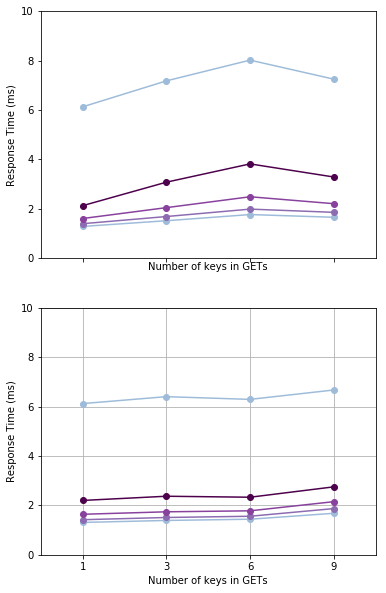

In [139]:
sharded_plot_percentiles = extract_percentiles(hist_data_sharded, multigets, desired_percentiles)
nonsharded_plot_percentiles = extract_percentiles(hist_data_nonsharded, multigets, desired_percentiles)

x = [1,2,3,4]
color_cycler = cycler('color', ['#9ebcda', '#8c6bb1', '#88419d', '#4d004b'])
def plot_percentiles_lines(ax, data):
    ax.set_prop_cycle(color_cycler)
    for key, grp in data.groupby(['percentile']):
        ax.plot(x, grp['responsetime'], marker='o')
    ax.set_xlabel("Number of keys in GETs")
    ax.set_ylabel("Response Time (ms)")
    ax.set_ylim([0,10])
    ax.set_xlim([0.5,4.5])
    ax.set_xticks(x)
    ax.set_xticklabels(('1', '3', '6', '9'))
    plt.grid()
    
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize=(6, 10))
plot_percentiles_lines(axes[0], sharded_plot_percentiles)
plot_percentiles_lines(axes[1], nonsharded_plot_percentiles)
plt.grid()
plt.show()

[ 1.     1.105  1.21   1.315  1.6    1.705  1.81   1.915  2.2    2.305
  2.41   2.515  2.8    2.905  3.01   3.115  3.4    3.505  3.61   3.715]
[ 1.    1.12  1.24  1.36  1.6   1.72  1.84  1.96  2.2   2.32  2.44  2.56
  2.8   2.92  3.04  3.16  3.4   3.52  3.64  3.76]


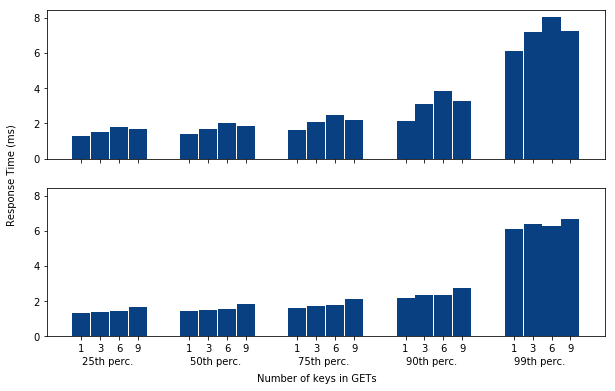

In [196]:
sharded_plot_percentiles

width=0.1
gap = 0.6
bargap=0.005
x = np.concatenate([np.arange(start=1+(i*gap), stop=1+(i*gap)+4*(width+bargap), step=(width+bargap)) for i in range(0, 5)])
print(x)
print(x2)
#for i in range(0,5):
#    print(x[(4*i):(4*i)+4])
def plot_percentiles_bar(ax, data):
    
    for i, (key, grp) in enumerate(data.groupby(['percentile'])):
    
        ax.bar(x[(4*i):(4*i)+4], grp['responsetime'], width=width, color='#084081')
        #ax.set_ylim([0,10])
        #ax.set_xlim([0.5,4.5])
        ax.set_xticks(x)
        #ax.set_xticklabels(grp['multigets'])
        ax.set_xticklabels(('1', '3', '6', '9', '1', '3', '6', '9', '1', '3', '6', '9', '1', '3', '6', '9', '1', '3', '6', '9'))


fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 6))

plot_percentiles_bar(axes[0], sharded_plot_percentiles)
plot_percentiles_bar(axes[1], nonsharded_plot_percentiles)

fig.text(0.5, 0.02, 'Number of keys in GETs', ha='center')
fig.text(0.07, 0.5, 'Response Time (ms)', va='center', rotation='vertical')
fig.text(0.21, 0.06, '25th perc.', ha='center')
fig.text(0.36, 0.06, '50th perc.', ha='center')
fig.text(0.51, 0.06, '75th perc.', ha='center')
fig.text(0.66, 0.06, '90th perc.', ha='center')
fig.text(0.81, 0.06, '99th perc.', ha='center')
plt.show()

In [221]:
# Get response times from MW for 6 multigets
def gather_requests(exp_dir, reps, middlewares):
    all_reps = []
    for rep in range(1, reps + 1):

        middleware_dirs = [dirfuncs.get_only_subdir(os.path.join(exp_dir, str(rep), mw_dir)) for mw_dir in middlewares]
        concatenated_requests = [gmws.concatenate_requestlogs(middleware_dir) for middleware_dir in middleware_dirs]


        filtered_requests = [reqs[reqs['requestType'].str.contains("GET")] for reqs in concatenated_requests]
        metrics = [gmws.extract_metrics(reqs) for reqs in filtered_requests]


        cut_metrics = [cut.cut_away_warmup_cooldown(mets, 10, 72) for mets in metrics]

        all_reps.extend(cut_metrics)
        
    return pd.concat(all_reps)

exp_dir_shard = os.path.join(exp5_1_dir, "sharded_6multiget")
exp_dir_nonshard = os.path.join(exp5_2_dir, "nonsharded_6multiget")
reps = 3
middlewares = ["middleware_04", "middleware_05"]

sharded_reqs_mw = gather_requests(exp_dir_shard, reps, middlewares)
nonsharded_reqs_mw = gather_requests(exp_dir_nonshard, reps, middlewares)


Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_6multiget/1/middleware_04/2017-11-24 090417
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_6multiget/1/middleware_05/2017-11-24 090417
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_6multiget/2/middleware_04/2017-11-24 091124
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_6multiget/2/middleware_05/2017-11-24 091125
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085912/sharded_6multiget/3/middleware_04/2017-11-24 091831
Concatenating requestlogs in /home/flo/Documents/eth-asl-final-experiment-data/exp5/5_1_multigets_sharded_2017-11-24_085

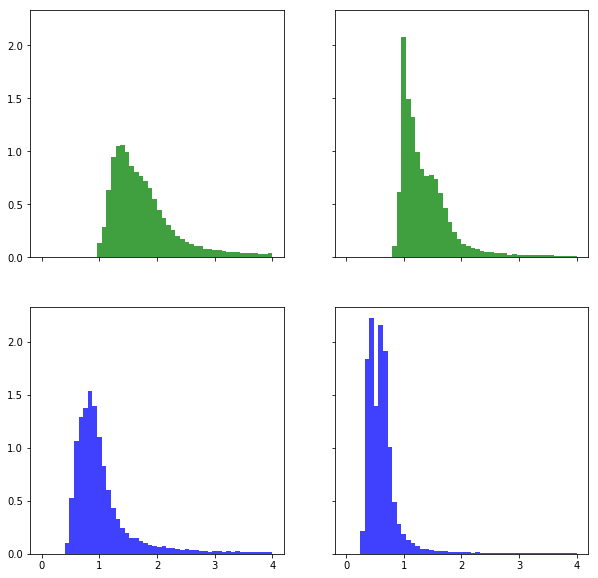

In [234]:
# Plot total histograms

sharded_reqs_mt = hist_data_sharded[2]
nonsharded_reqs_mt = hist_data_nonsharded[2]
xrng = [0, 4]
buckets = 50
num_subplots = len(hist_data_sharded)
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10,10))

axes[0,0].hist(sharded_reqs_mt['responsetime'], buckets, weights=sharded_reqs_mt['requests'], range=xrng, normed=1, facecolor='green', alpha=0.75)
axes[0,1].hist(nonsharded_reqs_mt['responsetime'], buckets, weights=nonsharded_reqs_mt['requests'], range=xrng, normed=1, facecolor='green', alpha=0.75)
axes[1,0].hist(sharded_reqs_mw['responseTime_ms'], buckets, range=xrng, normed=1, facecolor='blue', alpha=0.75)
axes[1,1].hist(nonsharded_reqs_mw['responseTime_ms'], buckets, range=xrng, normed=1, facecolor='blue', alpha=0.75)
plt.show()

In [224]:
sharded_reqs_mw

,middleware,requestType,initializeClockTime,queueLength,requestSize,responseSize,thread,numHits,numKeysRequested,queueTime_ms,workerServiceTime_ms,memcachedRTT_ms,netthreadServiceTime_ms,responseTime_us,responseTime_ms
timestep,,,,,,,,,,,,,,,
10.128,/home/flo/Documents/eth-asl-final-experiment-d...,ShardedGET,1511514271588,0,81,6321,55,6,6,0.063900,0.891004,0.873304,0.0018,956.704,0.956704
10.819,/home/flo/Documents/eth-asl-final-experiment-d...,ShardedGET,1511514272279,0,82,6322,55,6,6,0.023300,0.989704,0.974104,0.0024,1015.404,1.015404
10.989,/home/flo/Documents/eth-asl-final-experiment-d...,ShardedGET,1511514272449,2,82,6322,55,6,6,0.051900,0.846904,0.830004,0.0023,901.104,0.901104
11.799,/home/flo/Documents/eth-asl-final-experiment-d...,ShardedGET,1511514273259,0,79,6319,55,6,6,0.018900,1.045605,1.026605,0.0025,1067.005,1.067005
12.816,/home/flo/Documents/eth-asl-final-experiment-d...,ShardedGET,1511514274276,0,83,6323,55,6,6,0.033500,2.822812,2.805912,0.0022,2858.512,2.858512
13.783,/home/flo/Documents/eth-asl-final-experiment-d...,ShardedGET,1511514275243,0,82,6322,55,6,6,0.005000,0.832804,0.808004,0.0018,839.604,0.839604
14.031,/home/flo/Documents/eth-asl-final-experiment-d...,ShardedGET,1511514275491,0,82,6322,55,6,6,0.040000,1.181505,1.167705,0.0014,1222.905,1.222905
14.124,/home/flo/Documents/eth-asl-final-experiment-d...,ShardedGET,1511514275584,0,82,6322,55,6,6,0.069600,1.228505,1.155305,0.0013,1299.405,1.299405
15.052,/home/flo/Documents/eth-asl-final-experiment-d...,ShardedGET,1511514276512,0,81,6321,55,6,6,0.030201,0.825503,0.808003,0.0022,857.904,0.857904
